In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from datetime import datetime
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
def list_json_dir(folder):
    p = Path(folder)

    # list files in dir
    files = [f for f in p.iterdir() if f.suffix == '.json']
    return files

def read_json(f_path):
    with f_path.open('r') as fp:
        json_dict = json.load(fp)
        
    return json_dict

In [3]:
import matplotlib.pyplot as plt

# Origin problem
def plot_instance_col(df, instance, col):
    df_inst_col = df[df['instance'] == instance][['#expl','config', col, 'totTime']]
    df_inst_col['x'] = df_inst_col[col].apply(lambda x: [i for i in range(1, len(x) + 1)])
    df_inst_col = df_inst_col.sort_values(by=['totTime'], ascending=True)

    plt.figure(figsize=(30,30))
    for i, row in df_inst_col.iterrows():
        plt.plot(row['x'], row[col], label=row['config'])
        
    # Plot formatting
    plt.legend(fontsize=20)
    # plt.xlim((0, 50))
    plt.xlabel('Number of explanation steps', fontsize=20)
    plt.ylabel('Execution time (s) - timeout [7200s]', fontsize=20)
    plt.title(instance + " - " + col)
    plt.savefig('/home/crunchmonster/Desktop/figs/'+ datetime.now().strftime("%Y%m%d%H%M%S%f.jpg"), optimize=True, bbox_inches='tight')
    plt.show()


In [4]:
def plot_instance_post(df, instance, col):
    df_inst_col = df[df['instance'] == instance][['#expl','config', col, 'totTime']]
    df_inst_col['x'] = df_inst_col[col].apply(lambda x: [i for i in range(1, len(x) + 1)])
    df_inst_col = df_inst_col.sort_values(by=['totTime'], ascending=True)

    plt.figure(figsize=(30,15))
    for i, row in df_inst_col.iterrows():
        plt.plot(row['x'], row[col], label=row['config'])
        
    # Plot formatting
    plt.legend(fontsize=20, loc='upper left')
    plt.xlim((0, 20))
    plt.ylim((0, 2000))
    plt.xlabel('Number of explanation steps', fontsize=20)
    plt.ylabel('Execution time (s) - timeout [7200s]', fontsize=20)
    plt.title(instance + " - " + col)
    
    plt.show()


In [5]:
def jsonFilesToPandasDF(json_files):
    pd_dict = {
        # running parameters
        'timedout':[],
        'config':[],
        'cumul-ous': [],
        'cumul-sat':[],
        'cumul-post':[],
        'cumul-opt':[],
        'cumul-HS': [],
        'cumul-HS-all': [],
        'totTime': []
    }

    config_mapping = {
            'preseeding': 'pre',
            'preseeding-grow': 'pre-grow',
            'sat-polarity':'satpol',
            'sat-polarity-initial': 'satpol-ini',
            'postpone_opt_incr':'incr',
            'postpone_opt_greedy':'greedy',
            'grow_subset_maximal':'subset-max',
            'grow_sat':'grow_sat',
            'grow_maxsat_neg_cost':"MaxSat-A-neg",
            'grow_maxsat_pos_cost':"MaxSat-A-pos",
            'grow_maxsat_max_cost_neg': "MaxSat-A-inv",
            'grow_maxsat_unit': "MaxSat-unit", 
            'grow_maxsat_initial':  "MaxSat-init", 
            'grow_maxsat_actual_pos':  "MaxSat-pos",  
            'grow_maxsat_actual_unif': "MaxSat-unif", 
            'grow_maxsat_actual_inv': "MaxSat-inv"
    }

    for f_json in json_files:
        for k, v in f_json['config'].items():
            if k not in pd_dict:
                pd_dict[k] = []
            pd_dict[k].append(v)
        for k, v in f_json['results'].items():
            if k == 'timeout':
                pd_dict['timedout'].append(v)
                continue
            if k not in pd_dict:
                pd_dict[k] = []
            pd_dict[k].append(v)


        add_configs = [f_json['config']['instance'] if f_json['config']['instance'] != 'origin-problem' else 'puzzle']

        for k,v in f_json['config'].items():
            if v == True and k in config_mapping:
                add_configs.append(config_mapping[k])

        pd_dict['config'].append('_'.join(add_configs))
        pd_dict['cumul-ous'].append( [sum(f_json['results']['OUS-time'][:i+1]) for i in range(len(f_json['results']['OUS-time'])) ])
        pd_dict['totTime'].append(sum(f_json['results']['OUS-time']))
        pd_dict['cumul-opt'].append( [sum(f_json['results']['HS-opt-time'][:i+1]) for i in range(len(f_json['results']['HS-opt-time'])) ])
        pd_dict['cumul-post'].append( [sum(f_json['results']['HS-postpone-time'][:i+1]) for i in range(len(f_json['results']['HS-postpone-time'])) ])
        pd_dict['cumul-sat'].append( [sum(f_json['results']['SAT-time'][:i+1]) for i in range(len(f_json['results']['SAT-time'])) ])
        pd_dict['cumul-HS'].append( [sum(f_json['results']['HS'][:i+1]) for i in range(len(f_json['results']['HS'])) ])
        pd_dict['cumul-HS-all'].append( [sum(f_json['results']['HS'][:i+1])+sum(f_json['results']['HS_incr'][:i+1])+sum(f_json['results']['HS_greedy'][:i+1]) for i in range(len(f_json['results']['HS'])) ])

    return pd.DataFrame(pd_dict)

In [15]:
# processing the results
folder = 'effectPreseeding/2021010610'
files = list_json_dir(folder)
json_files = [read_json(f) for f in files]
dfjson = jsonFilesToPandasDF(json_files)


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
#dfjson.view()
# display(dfjson)
display(dfjson[["preseeding", "preseeding-grow"]])
# origin problem
origin = dfjson[dfjson["instance"] == "origin-problem"]

/home/crunchmonster/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


,preseeding,preseeding-grow
0,True,True
1,True,True
2,True,True
3,True,True
4,True,False
5,True,True
6,True,False
7,True,True
8,True,True
9,True,True


## Effect of preseeding with or without grow on the experiments.



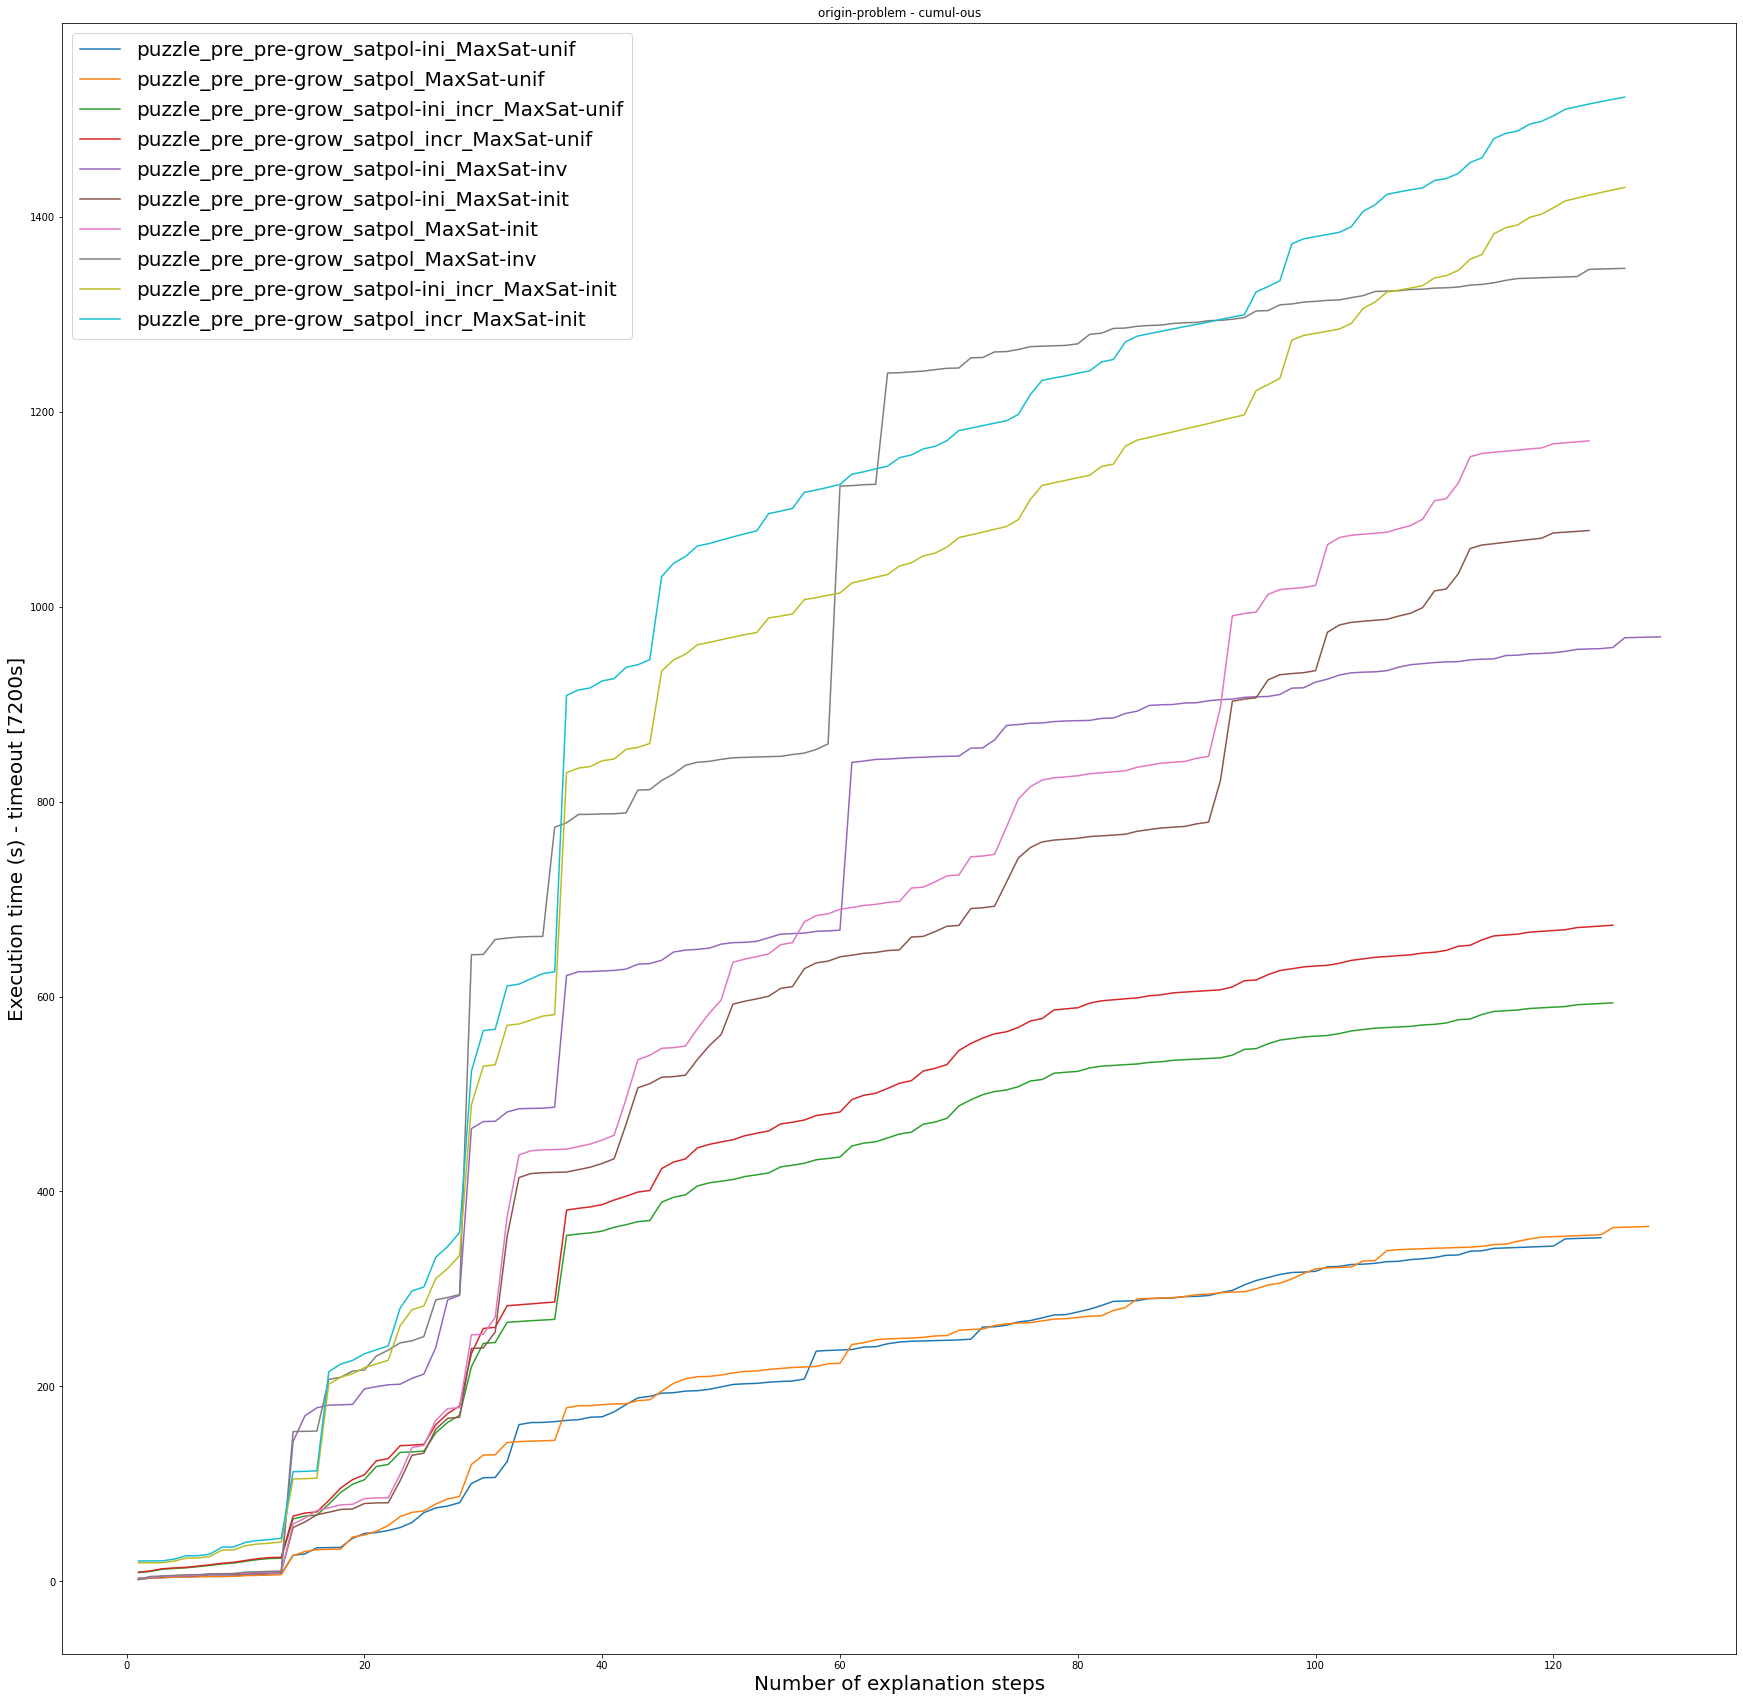

In [134]:

# checking the effect of grow
originNoTimeout = origin[origin["timedout"] == False]
originNoTimeoutSub2000 = originNoTimeout[originNoTimeout["totTime"] < 2000]

# grow in the pre-seeding state as well
plot_instance_col(originNoTimeoutSub2000, 'origin-problem', 'cumul-ous')

In [104]:
# checking the effect of grow
originProblemGrow = originProblem[originProblem['postpone_opt'] == False]

# grow in the pre-seeding state as well
plot_instance_col(originProblemGrow, 'origin-problem', 'cumul-ous')


KeyError: "['totTime'] not in index"

## RQ1

What is the effect of grow ?

- Subset-max grow: ***dominates all execution times***

    = Grow the found hitting-set:
        1. (1 step) try to set as much as the literals to polarity given by the initial intepreration. 
        2. (until no more changes in the model) Then set as much of polarities of the model to A .
            
            A = Actual intrepretation u {- facts to explain} 
- MaxSat: 

    = Hard clauses: CNF clauses + Hitting set clauses
    
    = Soft clasues: A \ Hitting set with costs 
    
            [-f(l) | l in {A \ Hitting set}]
            
- Sat: 

    = sat model where try to set as much as the literals to polarity given by the initial intepreration. 

In [16]:
# checking the effect of grow
originProblemGrow = originProblem[originProblem['postpone_opt'] == False]

# grow in the pre-seeding state as well
plot_instance_col(originProblemGrow, 'origin-problem', 'cumul-ous')


NameError: name 'originProblem' is not defined

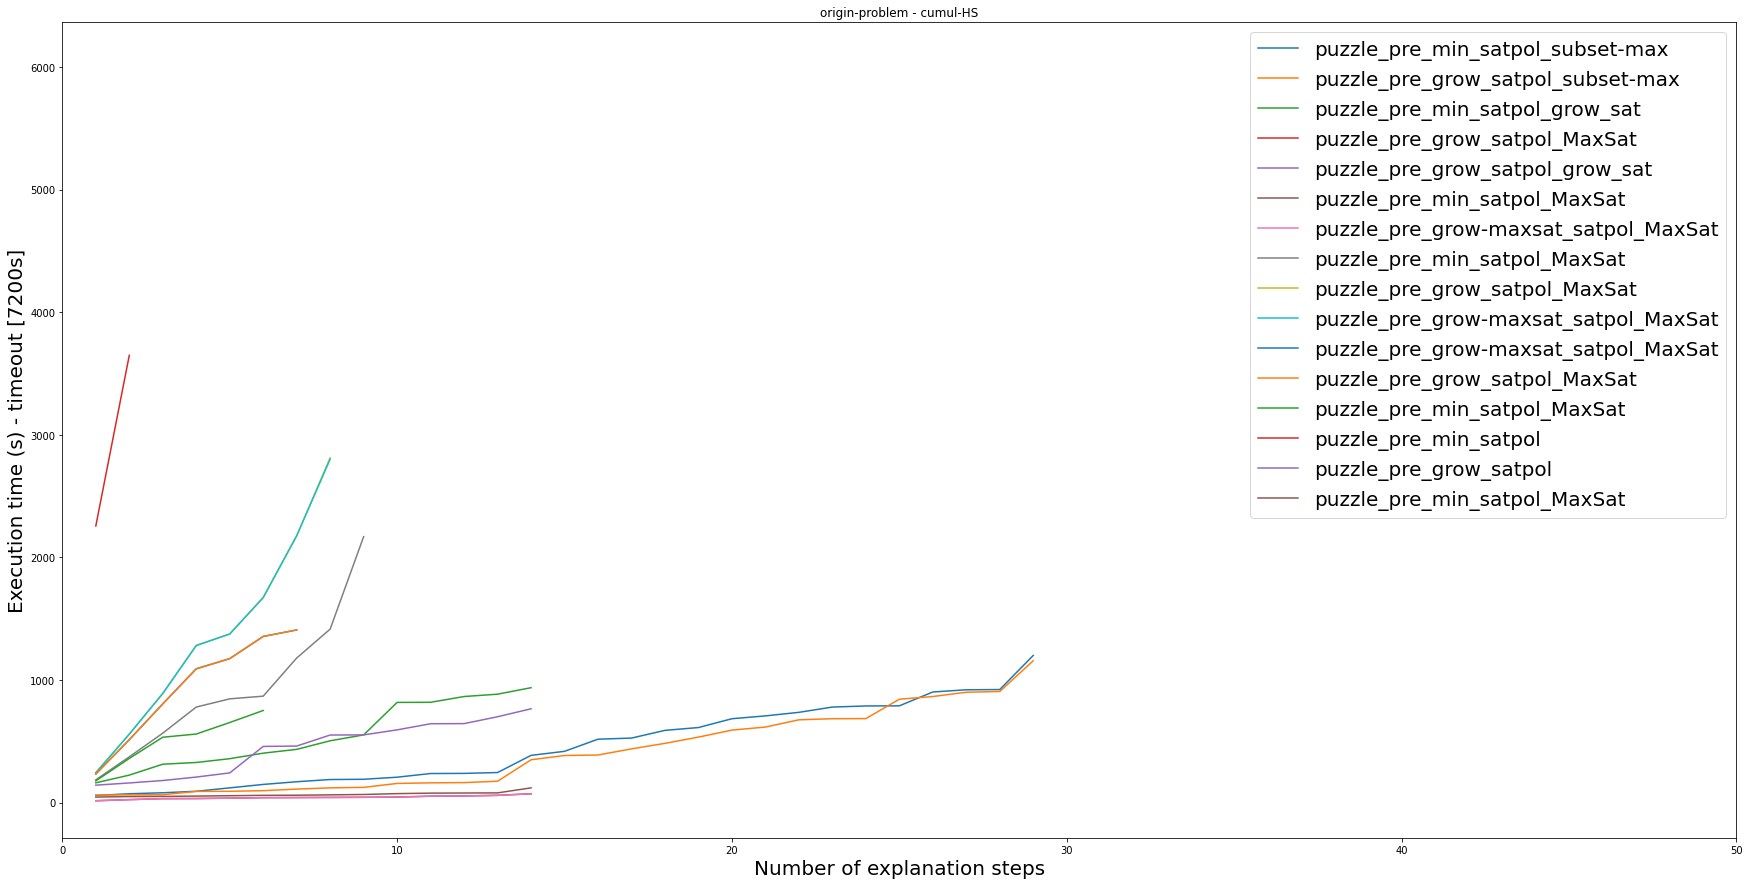

In [10]:
plot_instance_col(originProblemGrow, 'origin-problem', 'cumul-HS')

In [43]:
# checking the effect of grow
# originProblemPostponing = originProblem[(originProblem['postpone_opt'] == True) & (originProblem['grow_subset_maximal'] == True)]
originProblemPostponing = originProblem[(originProblem['grow_subset_maximal'] == True)]

## RQ2

- postponing -greedy:

    = 1. Add all clauses if unique in HS. 
      2. If p-literal not in current HS, Add the one which covers most sets-to-hit.
      3. Continue select literals until all sets-to-hit are hit by current assignment

- postponing -incr:

    = Select the clause with lowest cost not in p-constraint

What is the effect of postpnoning the optimisation ?

It doesn't improve it...

- post-poning greedy performs better than post-poning incremental 


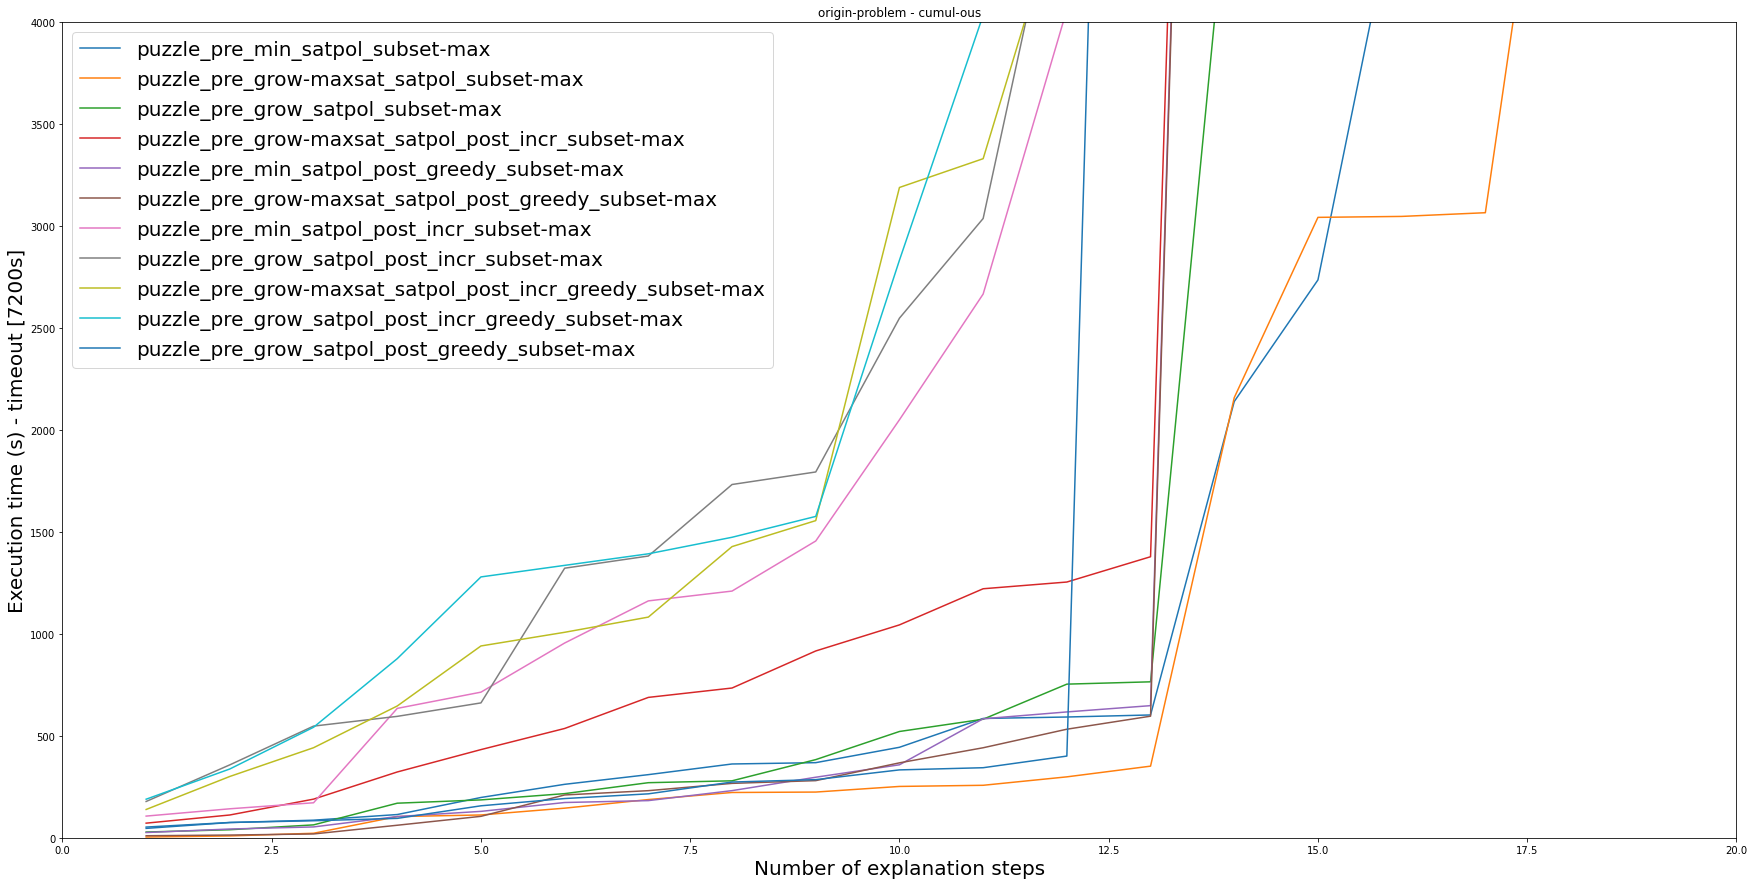

In [44]:
plot_instance_post(originProblemPostponing, 'origin-problem', 'cumul-ous')